In [1]:
### ==============================================================================
# FINAL SCRIPT FOR: CNN Prediction (with Robust Edge Handling)
# ==============================================================================

# --- STEP 1: SETUP ---
!pip install -q rasterio tensorflow scikit-learn

import os
import rasterio
import numpy as np
import tensorflow as tf
from rasterio.windows import Window
import joblib

# --- STEP 2: CONFIGURATION ---
full_image_path = "/kaggle/input/cnn-image/Singrauli_Merged_Image.tif"
model_path = "/kaggle/input/cnn-data/cnn_lulc_model_final.keras"
scaler_path = "/kaggle/input/cnn-data/cnn_scaler.joblib"
output_map_path = "/kaggle/working/Singrauli_CNN_L.tif"


# --- STEP 3: LOAD MODELS AND METADATA ---
print("\nLoading trained model and data scaler...")
try:
    model = tf.keras.models.load_model(model_path)
    scaler = joblib.load(scaler_path)
    
    with rasterio.open(full_image_path) as src:
        out_meta = src.meta.copy()
        height = src.height
        width = src.width
    
    _, PATCH_SIZE, _, BANDS = model.input_shape
    print(f"Model loaded. Processing in {PATCH_SIZE}x{PATCH_SIZE} tiles.")
    
except Exception as e:
    print(f"An error occurred during loading: {e}")
    raise e


# --- STEP 4: PREDICT ON THE IMAGE TILE BY TILE ---
out_meta.update({"count": 1, "dtype": 'uint8', "compress": 'lzw', "nodata": 255})
print("\nStarting tile-by-tile prediction...")

try:
    with rasterio.open(output_map_path, 'w', **out_meta) as dest:
        with rasterio.open(full_image_path) as src:
            
            width_steps = range(0, src.width, PATCH_SIZE)
            height_steps = range(0, src.height, PATCH_SIZE)
            total_blocks = len(width_steps) * len(height_steps)
            current_block = 0

            for j in height_steps:
                for i in width_steps:
                    current_block += 1
                    if current_block % 10 == 0:
                        print(f"Processing block {current_block} of {total_blocks}...")

                    # Define the window to read. It's always a full patch size.
                    read_window = Window(i, j, PATCH_SIZE, PATCH_SIZE)
                    
                    # Read the patch. `boundless=True` handles edges by filling with 0.
                    patch = src.read(window=read_window, boundless=True, fill_value=0)
                    
                    # --- Standard processing logic ---
                    bands, h_patch, w_patch = patch.shape
                    patch_flat = np.moveaxis(patch, 0, -1).reshape(-1, bands)
                    patch_flat = np.nan_to_num(patch_flat, nan=0.0)
                    patch_scaled = scaler.transform(patch_flat)
                    patch_for_pred = patch_scaled.reshape(1, h_patch, w_patch, bands)
                    pred_prob = model.predict(patch_for_pred, verbose=0)
                    pred_class = np.argmax(pred_prob, axis=-1)[0]
                    
                    # --- THIS IS THE FIX ---
                    # The `output_patch` is always the full size initially
                    output_patch = np.full((PATCH_SIZE, PATCH_SIZE), pred_class, dtype=np.uint8)
                    
                    # Calculate the actual window to write, which might be smaller at the edges.
                    write_window = Window(
                        i, j,
                        min(PATCH_SIZE, src.width - i),
                        min(PATCH_SIZE, src.height - j)
                    )
                    
                    # Trim the output patch if the write window is smaller
                    trimmed_patch = output_patch[:write_window.height, :write_window.width]
                    
                    # Write the (possibly trimmed) patch to the correct, valid window.
                    dest.write(trimmed_patch, window=write_window, indexes=1)

    print(f"\n✅ Prediction complete! Final map saved to: {output_map_path}")

except Exception as e:
    print(f"An error occurred during prediction: {e}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 80.5 MB/s eta 0:00:00


2025-06-25 13:21:57.901022: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750857718.129591      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750857718.184997      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered



Loading trained model and data scaler...


I0000 00:00:1750857734.004731      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750857734.005384      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model loaded. Processing in 64x64 tiles.

Starting tile-by-tile prediction...


I0000 00:00:1750857736.188858      66 service.cc:148] XLA service 0x7a8be80043d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750857736.189555      66 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1750857736.189574      66 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1750857736.305339      66 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1750857737.512697      66 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Processing block 10 of 26404...
Processing block 20 of 26404...
Processing block 30 of 26404...
Processing block 40 of 26404...
Processing block 50 of 26404...
Processing block 60 of 26404...
Processing block 70 of 26404...
Processing block 80 of 26404...
Processing block 90 of 26404...
Processing block 100 of 26404...
Processing block 110 of 26404...
Processing block 120 of 26404...
Processing block 130 of 26404...
Processing block 140 of 26404...
Processing block 150 of 26404...
Processing block 160 of 26404...
Processing block 170 of 26404...
Processing block 180 of 26404...
Processing block 190 of 26404...
Processing block 200 of 26404...
Processing block 210 of 26404...
Processing block 220 of 26404...
Processing block 230 of 26404...
Processing block 240 of 26404...
Processing block 250 of 26404...
Processing block 260 of 26404...
Processing block 270 of 26404...
Processing block 280 of 26404...
Processing block 290 of 26404...
Processing block 300 of 26404...
Processing block 31

In [2]:
# --- STEP 1: SETUP ---
!pip install -q rasterio tensorflow scikit-learn

import os
import rasterio
import numpy as np
import tensorflow as tf
from rasterio.windows import Window
import joblib
import math # Import math for ceiling division

# --- STEP 2: CONFIGURATION ---
full_image_path = "/kaggle/input/cnn-image/Singrauli_Merged_Image.tif"
model_path = "/kaggle/input/cnn-data/cnn_lulc_model_final.keras"
scaler_path = "/kaggle/input/cnn-data/cnn_scaler.joblib"
output_map_path = "/kaggle/working/Singrauli_CNN_L_Batched.tif"

# --- NEW: BATCH SIZE FOR PREDICTION ---
# This controls how many patches we predict on at once.
# 64 or 128 is a good start. Adjust based on your GPU memory.
PRED_BATCH_SIZE = 64

# --- STEP 3: LOAD MODELS AND METADATA ---
print("\nLoading trained model and data scaler...")
try:
    model = tf.keras.models.load_model(model_path)
    scaler = joblib.load(scaler_path)
    
    with rasterio.open(full_image_path) as src:
        out_meta = src.meta.copy()
        height = src.height
        width = src.width
    
    _, PATCH_SIZE, _, BANDS = model.input_shape
    print(f"Model loaded. Processing in {PATCH_SIZE}x{PATCH_SIZE} tiles with a batch size of {PRED_BATCH_SIZE}.")
    
except Exception as e:
    print(f"An error occurred during loading: {e}")
    raise e

# --- NEW STEP 4: HELPER FUNCTION FOR BATCH PROCESSING ---
# --- CORRECTED STEP 4: HELPER FUNCTION FOR BATCH PROCESSING ---
def process_and_write_batch(patches, windows, model, scaler, dest_file):
    """
    Takes a batch of patches, preprocesses them, predicts, and writes them to file.
    This version is corrected for an IMAGE CLASSIFICATION model.
    """
    patch_array = np.array(patches)
    b, bands, h_patch, w_patch = patch_array.shape
    
    # Preprocess the entire batch
    patch_array = np.moveaxis(patch_array, 1, -1)
    patch_flat = patch_array.reshape(-1, bands)
    patch_flat = np.nan_to_num(patch_flat, nan=0.0)
    patch_scaled = scaler.transform(patch_flat)
    patch_for_pred = patch_scaled.reshape(b, h_patch, w_patch, bands)
    
    # Predict on the entire batch
    pred_prob_batch = model.predict(patch_for_pred, verbose=0, batch_size=b)
    
    # Get the single class prediction for each patch in the batch
    pred_class_batch = np.argmax(pred_prob_batch, axis=-1) # Shape is now (batch_size,)

    # Write each predicted patch to its correct window
    for i in range(len(pred_class_batch)):
        # Get the single predicted class (e.g., 4) for this patch
        pred_class_scalar = pred_class_batch[i]
        write_window = windows[i]
        
        # --- THIS IS THE FIX ---
        # 1. Create a full 64x64 patch filled with the predicted class value.
        #    (We use PATCH_SIZE which should be a global variable, e.g. 64)
        output_patch = np.full((PATCH_SIZE, PATCH_SIZE), pred_class_scalar, dtype=np.uint8)
        
        # 2. Trim that new patch if we are at an edge.
        trimmed_patch = output_patch[:write_window.height, :write_window.width]
        
        # 3. Write the correctly sized patch to the correct location.
        dest_file.write(trimmed_patch, window=write_window, indexes=1)

# --- STEP 5: PREDICT ON THE IMAGE IN BATCHES ---
out_meta.update({"count": 1, "dtype": 'uint8', "compress": 'lzw', "nodata": 255})
print("\nStarting batched tile-by-tile prediction...")

try:
    with rasterio.open(output_map_path, 'w', **out_meta) as dest:
        with rasterio.open(full_image_path) as src:
            
            # Get the coordinates of all tiles to be processed
            width_steps = range(0, src.width, PATCH_SIZE)
            height_steps = range(0, src.height, PATCH_SIZE)
            all_coords = [(i, j) for j in height_steps for i in width_steps]
            total_blocks = len(all_coords)
            total_batches = math.ceil(total_blocks / PRED_BATCH_SIZE)

            print(f"Total patches to process: {total_blocks}")
            
            patches_to_predict = []
            write_windows = []

            for idx, (i, j) in enumerate(all_coords):
                # Define read and write windows
                read_window = Window(i, j, PATCH_SIZE, PATCH_SIZE)
                write_window = Window(
                    i, j,
                    min(PATCH_SIZE, src.width - i),
                    min(PATCH_SIZE, src.height - j)
                )

                # Read the patch and add it and its window to our lists
                patch = src.read(window=read_window, boundless=True, fill_value=0)
                patches_to_predict.append(patch)
                write_windows.append(write_window)

                # If the batch is full, or if this is the last patch, process the batch
                is_last_patch = (idx + 1) == total_blocks
                if len(patches_to_predict) == PRED_BATCH_SIZE or is_last_patch:
                    current_batch_num = (idx // PRED_BATCH_SIZE) + 1
                    print(f"Processing batch {current_batch_num} of {total_batches}...")
                    
                    # Call the helper function to do the work
                    process_and_write_batch(patches_to_predict, write_windows, model, scaler, dest)
                    
                    # Clear the lists to prepare for the next batch
                    patches_to_predict = []
                    write_windows = []

    print(f"\n✅ Prediction complete! Final map saved to: {output_map_path}")

except Exception as e:
    print(f"An error occurred during prediction: {e}")


Loading trained model and data scaler...
Model loaded. Processing in 64x64 tiles with a batch size of 64.

Starting batched tile-by-tile prediction...
Total patches to process: 26404
Processing batch 1 of 413...
Processing batch 2 of 413...
Processing batch 3 of 413...
Processing batch 4 of 413...
Processing batch 5 of 413...
Processing batch 6 of 413...
Processing batch 7 of 413...
Processing batch 8 of 413...
Processing batch 9 of 413...
Processing batch 10 of 413...
Processing batch 11 of 413...
Processing batch 12 of 413...
Processing batch 13 of 413...
Processing batch 14 of 413...
Processing batch 15 of 413...
Processing batch 16 of 413...
Processing batch 17 of 413...
Processing batch 18 of 413...
Processing batch 19 of 413...
Processing batch 20 of 413...
Processing batch 21 of 413...
Processing batch 22 of 413...
Processing batch 23 of 413...
Processing batch 24 of 413...
Processing batch 25 of 413...
Processing batch 26 of 413...
Processing batch 27 of 413...
Processing batc

Displaying classified map from: /kaggle/working/Singrauli_CNN_L_Batched.tif


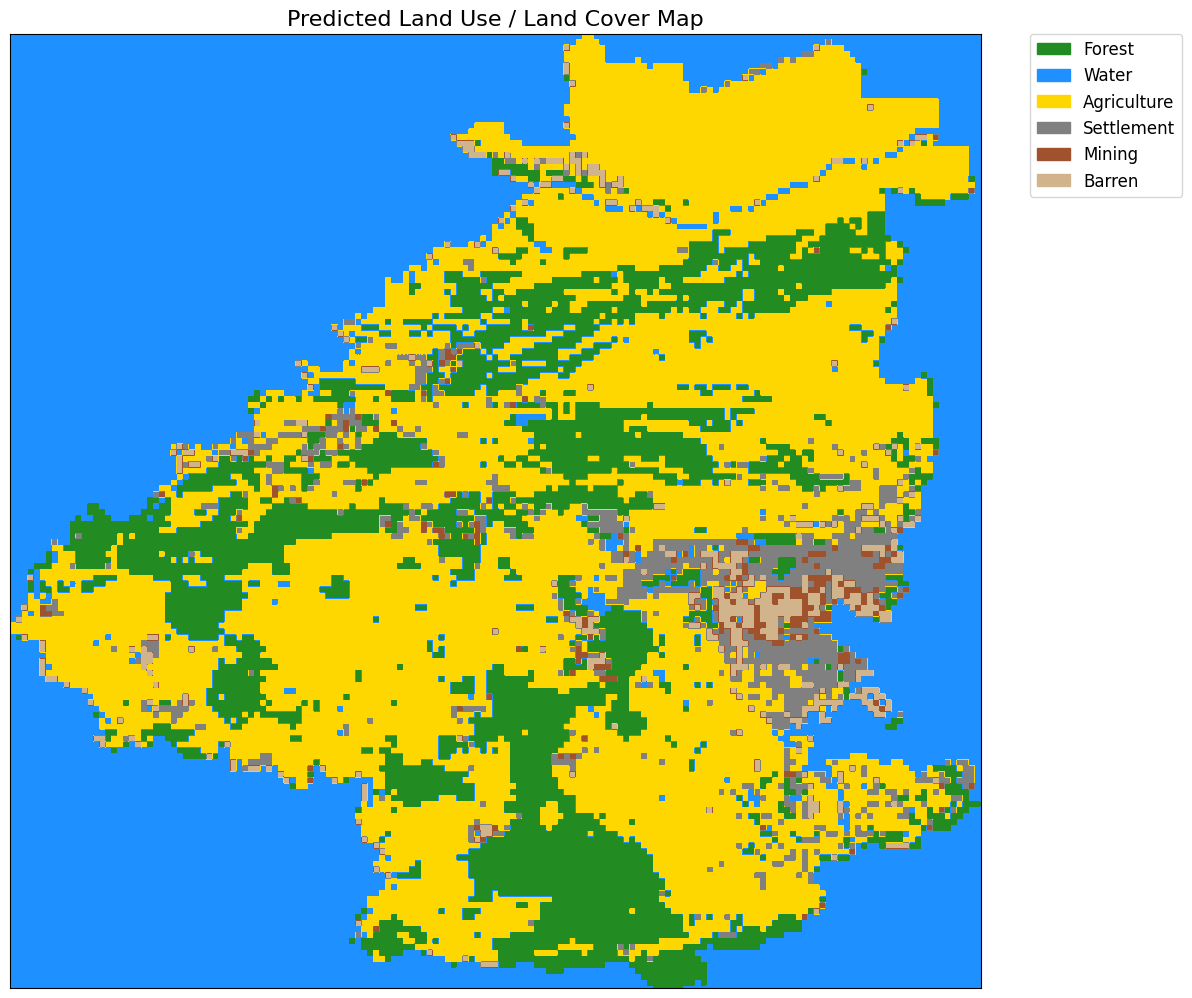

In [3]:
# --- Code Snippet to Visualize the Output Classified Map ---

import rasterio
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as mpatches
import numpy as np

# --- Configuration ---
# Use the same output path from your prediction script
# IMPORTANT: Make sure this path is correct
output_map_path = "/kaggle/working/Singrauli_CNN_L_Batched.tif"

# Define the same class names and pick a color for each.
# The order must match your class indices (0='Forest', 1='Water', etc.)
CLASS_NAMES = ['Forest', 'Water', 'Agriculture', 'Settlement', 'Mining', 'Barren']

# You can change these colors to your preference
CLASS_COLORS = [
    '#228B22',  # Forest Green
    '#1E90FF',  # Dodger Blue
    '#FFD700',  # Gold (for Agriculture)
    '#808080',  # Gray (for Settlement)
    '#A0522D',  # Sienna (for Mining)
    '#D2B48C'   # Tan (for Barren)
]

# --- Visualization Logic ---
print(f"Displaying classified map from: {output_map_path}")

try:
    with rasterio.open(output_map_path) as src:
        # Read the first band of the classified image
        classified_data = src.read(1)
        
        # Get the nodata value from the file's metadata
        nodata_value = src.nodata

        # Mask out the nodata values so they appear transparent
        if nodata_value is not None:
            classified_data = np.ma.masked_equal(classified_data, nodata_value)

        # Create a colormap from our list of colors
        cmap = colors.ListedColormap(CLASS_COLORS)
        
        # Create a normalization object to map class indices (0-5) to our colors
        # The boundaries ensure that each integer gets one distinct color.
        bounds = np.arange(len(CLASS_NAMES) + 1) - 0.5
        norm = colors.BoundaryNorm(bounds, cmap.N)

        # Create the plot
        fig, ax = plt.subplots(figsize=(12, 12))
        
        # Display the data using imshow
        im = ax.imshow(classified_data, cmap=cmap, norm=norm)

        # --- Create a custom legend ---
        # Create a patch for each class label and color
        patches = [mpatches.Patch(color=color, label=label) 
                   for color, label in zip(CLASS_COLORS, CLASS_NAMES)]
        
        # Add the legend to the plot outside the main image area
        ax.legend(handles=patches, 
                  bbox_to_anchor=(1.05, 1), 
                  loc='upper left', 
                  borderaxespad=0.,
                  fontsize='large')

        # --- Final Touches ---
        ax.set_title('Predicted Land Use / Land Cover Map', fontsize=16)
        ax.set_xticks([]) # Hide axis numbers
        ax.set_yticks([])
        
        fig.tight_layout()
        plt.show()

except FileNotFoundError:
    print(f"Error: The file was not found at '{output_map_path}'")
    print("Please ensure the prediction script ran successfully and the path is correct.")
except Exception as e:
    print(f"An error occurred: {e}")